In [1]:
# Check GPU status
import torch

if torch.cuda.is_available():
    print("✅ GPU is available:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU is NOT available. You're likely on CPU (quota used up).")


✅ GPU is available: Tesla T4


#import metadata for dataset

In [2]:
from google.colab import auth
import os
import pandas as pd
import fsspec
auth.authenticate_user()

# Paths to the metadata files in Google Cloud Storage
metadata_path_cafe1 = 'gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'
metadata_path_cafe2 = 'gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv'

# Function to load metadata from a given GCS path
def load_metadata_from_gcs(gcs_path):
    try:
        with fsspec.open(gcs_path, 'r') as f:
            # Try different separators
            for sep in [',', '\t', ';']:
                try:
                    metadata_df = pd.read_csv(f, sep=sep, on_bad_lines='skip', header=None)
                    # If successful, rename the first column and set it as index
                    if not metadata_df.empty:
                        metadata_df.rename(columns={metadata_df.columns[0]: 'dish_id'}, inplace=True)
                        if 'dish_id' in metadata_df.columns:
                            metadata_df.set_index('dish_id', inplace=True)
                            print(f"Successfully loaded metadata from {gcs_path} with separator '{sep}'")
                            return metadata_df
                        else:
                            print(f"Error: 'dish_id' column not found after renaming in {gcs_path}.")
                            return pd.DataFrame()
                except Exception as e:
                    print(f"Error reading {gcs_path} with separator '{sep}': {e}")
                    f.seek(0) # Reset file pointer to try another separator
            print(f"Could not read the CSV from {gcs_path} with common separators.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error opening metadata file from GCS: {e}")
        return pd.DataFrame()


# Load metadata from both files
metadata_df1 = load_metadata_from_gcs(metadata_path_cafe1)
metadata_df2 = load_metadata_from_gcs(metadata_path_cafe2)

# Concatenate the dataframes if both loaded successfully
if not metadata_df1.empty and not metadata_df2.empty:
    metadata_df = pd.concat([metadata_df1, metadata_df2])
    print("\nCombined metadata from both files.")
    # Display the first few rows to verify
    print("Portion of the combined metadata:")
    print(metadata_df.head())
elif not metadata_df1.empty:
    metadata_df = metadata_df1
    print("\nOnly metadata from cafe1.csv was loaded.")
    print("Portion of the metadata:")
    print(metadata_df.head())
elif not metadata_df2.empty:
    metadata_df = metadata_df2
    print("\nOnly metadata from cafe2.csv was loaded.")
    print("Portion of the metadata:")
    print(metadata_df.head())
else:
    metadata_df = pd.DataFrame()
    print("\nCould not load metadata from either file.")

Successfully loaded metadata from gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv with separator ','
Successfully loaded metadata from gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv with separator ','

Combined metadata from both files.
Portion of the combined metadata:
                        1      2          3          4          5    \
dish_id                                                               
dish_1561662216  300.794281  193.0  12.387489  28.218290  18.633970   
dish_1562688426  137.569992   88.0   8.256000   5.190000  10.297000   
dish_1561662054  419.438782  292.0  23.838249  26.351543  25.910593   
dish_1562008979  382.936646  290.0  22.224644  10.173570  35.345387   
dish_1560455030   20.590000  103.0   0.148000   4.625000   0.956000   

                             6                 7          8          9    \
dish_id                                                                    
dish_1561662216  i

#create custom dataset


In [3]:
from datasets import Dataset, Features, Image as HFImage, Value
import os
import fsspec
from PIL import Image # Import PIL to open images with fsspec
import re # Import re for regular expressions
import os
import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zygmuntyt/nutrition5k-dataset-side-angle-images")
# Directory containing the images in Google Cloud Storage
image_dir_gcs = 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead'
root_directory =path

# Prepare a list to hold our structured data
data_records = []

print("\nScanning images and linking metadata...")

# Use fsspec to list all directories in the GCS image path
fs = fsspec.filesystem('gs')
try:
    # List all entries in the directory
    all_gcs_entries = fs.ls(image_dir_gcs)

    # Filter for directories that look like dish IDs (starting with 'dish_')
    dish_directories = [entry.split('/')[-1] for entry in all_gcs_entries if fs.isdir(entry) and re.match(r'dish_\d+', entry.split('/')[-1])]

    print(f"Found {len(dish_directories)} dish directories in GCS.")
    count=0
    # Iterate through each dish directory found in GCS
    for dish_id in dish_directories:
        target_folder=dish_id

        folder_path = os.path.join(root_directory, target_folder, 'frames_sampled30')
        if os.path.isdir(folder_path):
            image_files = os.listdir(folder_path)

            # Construct the GCS path for the image
            # image_path_gcs = f"{image_dir_gcs}/{dish_id}/rgb.png"
            for i, image_file in enumerate(image_files, start=1):
              image_path_gcs = os.path.join(folder_path, image_file)
              # Check if the dish_id exists in the metadata
              if dish_id in metadata_df.index:
                  # Look up the record for the dish_id
                  record = metadata_df.loc[dish_id]

                  # Access the second ingredient column
                  # Assuming column index 14 is the second ingredient's ID based on previous output
                  second_ingr = record.iloc[13] # Use iloc for integer-based indexing


                  # Only include dishes with exactly one ingredient (check if the second ingredient is NaN)
                  if str(second_ingr) == 'nan':
                      # Access the mass value from column with index 2 - total mass in grams
                      mass = record.iloc[1] # Use iloc for integer-based indexing
                      # Access the carbohydrate value from column with index 4 - total carbs in grams
                      carbs = record.iloc[3] # Use iloc for integer-based indexing
                      # Access the meal name from column with index 7
                      meal_name = record.iloc[6] # Use iloc for integer-based indexing


                      # Add the GCS image path and its values to our list
                      data_records.append({
                          'image': image_path_gcs,
                          'image_path': image_path_gcs, # Store the GCS path
                          'mass': float(mass),
                          'carbs': float(carbs), # Ensure carbs is a float
                          'meal_name': str(meal_name) # Ensure meal_name is a string
                      })
                      count+=1
                  else:
                      # Optional: print dish IDs that were skipped
                      # print(f"Skipping {dish_id} as it has more than one ingredient.")
                      pass # Skip dishes with more than one ingredient

except Exception as e:
    print(f"Error listing or processing GCS directories: {e}")


print(f"Found {count} images with corresponding metadata")

# Define a function to load the image using fsspec and PIL
def load_image_from_gcs(image_path_gcs):
    with fsspec.open(image_path_gcs, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB') # Ensure image is in RGB format


# Create the Dataset object from our list of dictionaries
# Define features, including the image_path as an Image feature
nutrition_dataset_full = Dataset.from_list(
    data_records,
    features=Features({
        'image': HFImage(), # Define the image_path column as an Image feature
        'image_path': Value('string'), # Store the GCS path as a string
        'mass': Value('float32'),
        'carbs': Value('float32'),
        'meal_name': Value('string'),
    })
)



print("\n✅ Hugging Face Dataset created successfully, accessing images from GCS!")
print(nutrition_dataset_full)



Using Colab cache for faster access to the 'nutrition5k-dataset-side-angle-images' dataset.

Scanning images and linking metadata...
Found 3490 dish directories in GCS.
Found 6760 images with corresponding metadata

✅ Hugging Face Dataset created successfully, accessing images from GCS!
Dataset({
    features: ['image', 'image_path', 'mass', 'carbs', 'meal_name'],
    num_rows: 6760
})


#train-test split

In [4]:
# Split the dataset into training and testing sets
train_test_split = nutrition_dataset_full.train_test_split(test_size=0.2) # Using 20% of data for testing

# Access the splits
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

print("\nDataset split into training and testing sets.")
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

print("\n✅ Dataset split successfully!")


Dataset split into training and testing sets.
Training set size: 5408
Testing set size: 1352

✅ Dataset split successfully!


# example images

Displaying 5 random examples from the training dataset:


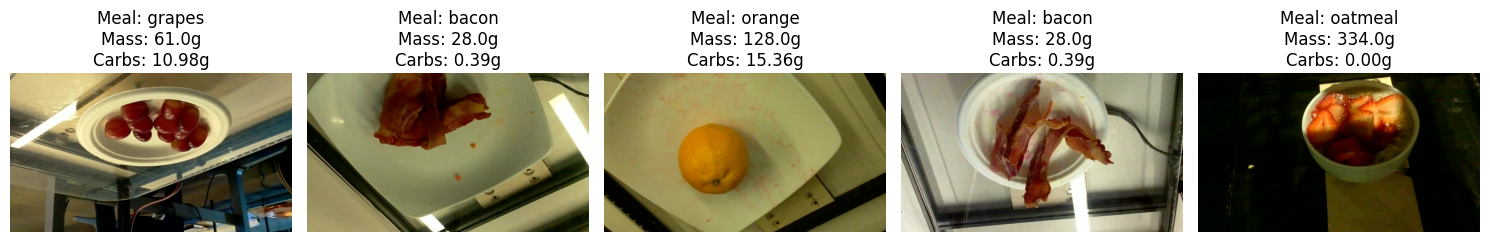

avg carbs in test set: 8.823939389692477


In [ ]:
import matplotlib.pyplot as plt
import random
import os

# Choose how many examples to display
num_examples = 5

# Get random indices from the training dataset
# Using the training dataset as an example, could also use the test_dataset
random_indices = random.sample(range(len(train_dataset)), min(num_examples, len(train_dataset)))

print(f"Displaying {len(random_indices)} random examples from the training dataset:")

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    example = train_dataset[idx]
    image = example['image']
    carbs = example['carbs']
    meal_name = example['meal_name']
    mass= example['mass']

    plt.subplot(1, len(random_indices), i + 1)
    plt.imshow(image)
    plt.title(f"Meal: {meal_name}\nMass: {mass}g\nCarbs: {carbs:.2f}g")
    plt.axis('off')

plt.tight_layout()
plt.show()

total_carbs_tests=0
for example in test_dataset:
    # example = test_dataset[idx]
    carbs = example['carbs']
    total_carbs_tests+=carbs

print(f"avg carbs in test set: {total_carbs_tests/len(test_dataset)}")

# train and evaluate model

In [6]:
import os
# Enable CUDA synchronous error reporting for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets.folder import default_loader
from torchvision.transforms import TrivialAugmentWide
from datasets import load_dataset
from PIL import Image
from torchvision.models import EfficientNet_B3_Weights
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision import transforms

import random

# 1. Load full dataset
raw_ds = nutrition_dataset_full
# build label mapping from entire dataset to cover all splits
all_meals = nutrition_dataset_full.unique('meal_name')

label2id = {name: idx for idx, name in enumerate(all_meals)}
id2label = {idx: name for name, idx in label2id.items()}
num_classes = len(all_meals)

train_split = train_dataset
val_split = test_dataset

input_size = 380 #for B4
weights = EfficientNet_B4_Weights.DEFAULT
transform = weights.transforms()  # includes resizing to 380x380, normalization, etc.


# 4. Dataset wrapper
class NutritionTorchDataset(Dataset):
    def __init__(self, hf_ds):
        self.ds = hf_ds
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img_data = ex['image']
        if isinstance(img_data, (str, bytes, os.PathLike)):
            pil = default_loader(img_data)
        elif isinstance(img_data, Image.Image):
            pil = img_data
        else:
            pil = default_loader(img_data.get('path'))
        x = self.transform(pil)
        meal = ex['meal_name']
        if meal not in self.label2id:
            raise ValueError(f"Unknown meal_name '{meal}' at index {idx}")
        y_cls = torch.tensor(self.label2id[meal], dtype=torch.long)
        y_reg = torch.tensor(float(ex['carbs']), dtype=torch.float)
        return {'pixel_values': x, 'label': y_cls, 'carbs_val': y_reg}


# 5. Prepare DataLoaders

train_ds = NutritionTorchDataset(train_split)
val_ds = NutritionTorchDataset(val_split)


batch_size = 16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


# 6. Model definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MultiTaskEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.efficientnet_b4(weights=weights)

        in_feats = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        self.dropout = nn.Dropout(0.2)
        self.cls_head = nn.Linear(in_feats, num_classes)
        self.reg_head = nn.Sequential(
            nn.Linear(in_feats, num_classes),
            nn.Softplus(beta=1.0) # smooth ReLU; allways >= 0
        )

    def forward(self, x):
        feats = self.backbone.features(x)
        pooled = self.backbone.avgpool(feats)
        flat = torch.flatten(pooled,1)
        flat = self.dropout(flat)
        logits = self.cls_head(flat)     # [B, K]
        carbs_vec = self.reg_head(flat)  # [B, K]  <-- per-class carbs
        return logits, carbs_vec

model = MultiTaskEfficientNet(num_classes).to(device)


# 7. Losses, optimizer & scheduler
criterion_cls = nn.CrossEntropyLoss()
criterion_reg = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(f"Training set size: {len(train_loader)}")
print(f"Testing set size: {len(val_loader)}")





# 8. Training & evaluation loops with MAPE


for epoch in range(1, 11):
    model.train()
    total_cls, total_reg = 0.0, 0.0
    correct, total = 0, 0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
        imgs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        carbs = batch['carbs_val'].to(device)
        optimizer.zero_grad()
        logits, carbs_vec = model(imgs)                             # carbs_vec: [B, K]
        loss_cls = criterion_cls(logits, labels)
        carbs_true = carbs_vec.gather(1, labels.unsqueeze(1)).squeeze(1)  # [B]
        loss_reg = criterion_reg(carbs_true, carbs)

        loss = loss_cls + 2.0* loss_reg


        loss.backward()
        optimizer.step()
        total_cls += loss_cls.item() * imgs.size(0)
        total_reg += loss_reg.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch} Train — Acc: {correct/total:.4f}, l1loss: {total_reg/total:.4f}")

    # Validation
    model.eval()
    val_cls, val_reg, val_rel = 0.0, 0.0, 0.0
    correct, total = 0, 0
    total_mae = 0.0  # Initialize total MAE for the epoch
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
            imgs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            carbs = batch['carbs_val'].to(device)
            logits, carbs_vec = model(imgs)
            loss_c = criterion_cls(logits, labels)
            carbs_true = carbs_vec.gather(1, labels.unsqueeze(1)).squeeze(1)
            loss_r = criterion_reg(carbs_true, carbs)
            val_cls += loss_c.item() * imgs.size(0)
            val_reg += loss_r.item() * imgs.size(0)

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

            total_mae += torch.sum(torch.abs(carbs_true - carbs)).item()


    avg_acc = correct/total
    avg_l1 = val_reg/total
    avg_mae = total_mae / total # Calculate average MAE

    print(f"Epoch {epoch} Val — Acc: {avg_acc:.4f}, L1 loss: {avg_l1:.4f}, MAE: {avg_mae:.4f}")



Training set size: 338
Testing set size: 85


Train Epoch 1: 100%|██████████| 338/338 [07:08<00:00,  1.27s/it]


Epoch 1 Train — Acc: 0.2777, l1loss: 4.2564


Val Epoch 1: 100%|██████████| 85/85 [01:07<00:00,  1.25it/s]


Epoch 1 Val — Acc: 0.5200, L1 loss: 2.1160, MAE: 2.4868


Train Epoch 2: 100%|██████████| 338/338 [07:02<00:00,  1.25s/it]


Epoch 2 Train — Acc: 0.5716, l1loss: 1.8930


Val Epoch 2: 100%|██████████| 85/85 [01:03<00:00,  1.34it/s]


Epoch 2 Val — Acc: 0.7101, L1 loss: 1.6519, MAE: 2.0188


Train Epoch 3: 100%|██████████| 338/338 [07:00<00:00,  1.24s/it]


Epoch 3 Train — Acc: 0.6986, l1loss: 1.5176


Val Epoch 3: 100%|██████████| 85/85 [01:03<00:00,  1.34it/s]


Epoch 3 Val — Acc: 0.7766, L1 loss: 1.4427, MAE: 1.7924


Train Epoch 4: 100%|██████████| 338/338 [07:01<00:00,  1.25s/it]


Epoch 4 Train — Acc: 0.7661, l1loss: 1.2754


Val Epoch 4: 100%|██████████| 85/85 [01:03<00:00,  1.35it/s]


Epoch 4 Val — Acc: 0.8173, L1 loss: 1.2789, MAE: 1.6225


Train Epoch 5: 100%|██████████| 338/338 [06:59<00:00,  1.24s/it]


Epoch 5 Train — Acc: 0.8127, l1loss: 1.1426


Val Epoch 5: 100%|██████████| 85/85 [01:02<00:00,  1.36it/s]


Epoch 5 Val — Acc: 0.8506, L1 loss: 1.2195, MAE: 1.5658


Train Epoch 6: 100%|██████████| 338/338 [07:02<00:00,  1.25s/it]


Epoch 6 Train — Acc: 0.8388, l1loss: 1.0237


Val Epoch 6: 100%|██████████| 85/85 [01:03<00:00,  1.35it/s]


Epoch 6 Val — Acc: 0.8780, L1 loss: 1.1636, MAE: 1.5145


Train Epoch 7: 100%|██████████| 338/338 [06:59<00:00,  1.24s/it]


Epoch 7 Train — Acc: 0.8597, l1loss: 0.9524


Val Epoch 7: 100%|██████████| 85/85 [01:02<00:00,  1.36it/s]


Epoch 7 Val — Acc: 0.8868, L1 loss: 1.1545, MAE: 1.5013


Train Epoch 8: 100%|██████████| 338/338 [06:57<00:00,  1.24s/it]


Epoch 8 Train — Acc: 0.8842, l1loss: 0.8818


Val Epoch 8: 100%|██████████| 85/85 [01:02<00:00,  1.36it/s]


Epoch 8 Val — Acc: 0.9009, L1 loss: 1.0622, MAE: 1.3995


Train Epoch 9: 100%|██████████| 338/338 [06:57<00:00,  1.24s/it]


Epoch 9 Train — Acc: 0.8924, l1loss: 0.8272


Val Epoch 9: 100%|██████████| 85/85 [01:01<00:00,  1.37it/s]


Epoch 9 Val — Acc: 0.9090, L1 loss: 1.0397, MAE: 1.3656


Train Epoch 10: 100%|██████████| 338/338 [06:57<00:00,  1.24s/it]


Epoch 10 Train — Acc: 0.9050, l1loss: 0.7618


Val Epoch 10: 100%|██████████| 85/85 [01:01<00:00,  1.37it/s]

Epoch 10 Val — Acc: 0.9120, L1 loss: 0.9755, MAE: 1.3078


# confusion matrix

Top-1 acc: 0.9120 | Top-3 acc: 0.9786

Per-class report:
                       precision    recall  f1-score   support

               olives      1.000     0.912     0.954        34
         mixed greens      0.867     0.812     0.839        32
     brussels sprouts      1.000     1.000     1.000         9
               celery      1.000     1.000     1.000         5
           plate only      1.000     0.462     0.632        13
         strawberries      0.893     0.962     0.926        26
                 eggs      0.957     0.957     0.957        23
                  yam      0.781     1.000     0.877        25
                 fish      0.737     1.000     0.848        14
             eggplant      1.000     0.857     0.923         7
         caesar salad      0.947     0.973     0.960        74
              chicken      1.000     1.000     1.000        14
          cauliflower      0.974     1.000     0.987        38
                steak      1.000     1.000     1.000        

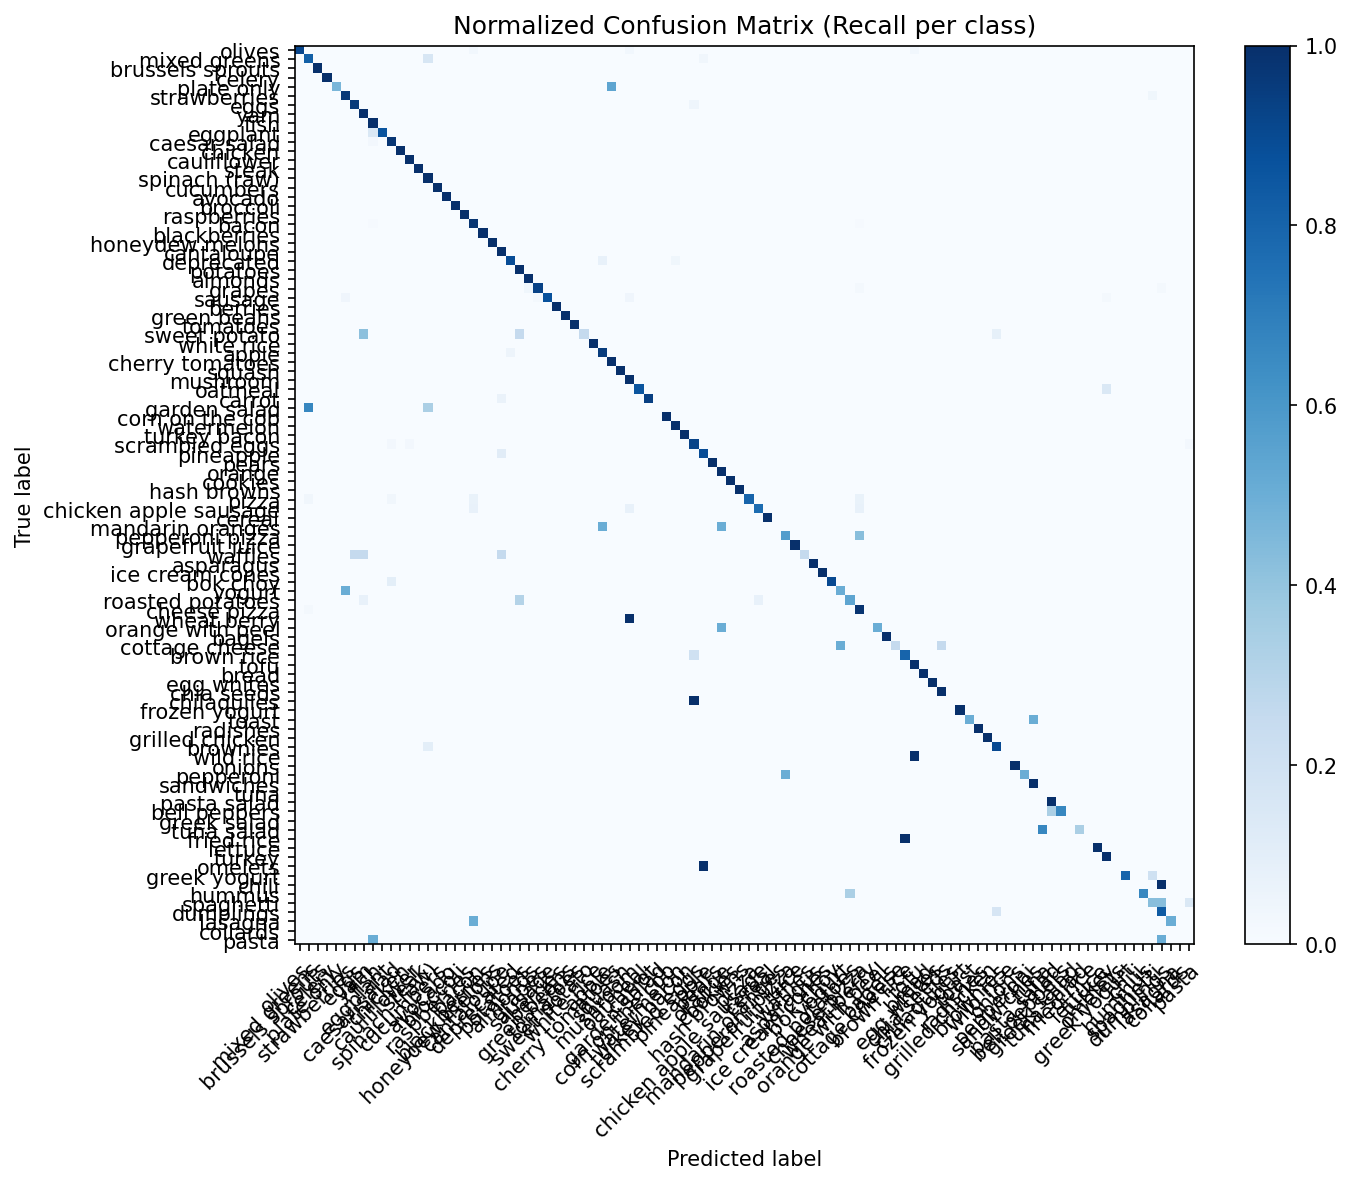

In [7]:
# eval_confusion.py (or a cell)

import numpy as np, torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class_names=all_meals
model.eval()
all_labels, all_preds, all_top3 = [], [], []

with torch.no_grad():
    for batch in val_loader:
        x = batch['pixel_values'].to(device)
        y = batch['label'].to(device)

        logits, _ = model(x)
        probs = F.softmax(logits, dim=1)

        # top-1
        pred = probs.argmax(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(y.cpu().numpy())

        # top-3 correct flags
        top3 = torch.topk(probs, k=min(3, probs.shape[1]), dim=1).indices
        top3_hit = (top3 == y.view(-1,1)).any(dim=1).cpu().numpy()
        all_top3.append(top3_hit)

all_labels = np.concatenate(all_labels)
all_preds  = np.concatenate(all_preds)
all_top3   = np.concatenate(all_top3)

top1_acc = (all_preds == all_labels).mean()
top3_acc = all_top3.mean()
print(f"Top-1 acc: {top1_acc:.4f} | Top-3 acc: {top3_acc:.4f}")


from sklearn.metrics import confusion_matrix, classification_report

labels = list(range(len(class_names)))

# Confusion matrix (normalized by true class → per-class recall)
cm = confusion_matrix(all_labels, all_preds, labels=labels, normalize='true')

# Text report (precision/recall/F1 per class)
print("\nPer-class report:")
print(classification_report(
    all_labels, all_preds,
    labels=labels,
    target_names=class_names,
    zero_division=0,
    digits=3
))

# Plot and save confusion matrix
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predicted label', ylabel='True label',
       title='Normalized Confusion Matrix (Recall per class)')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# show only a few tick labels if you have many classes
max_ticks = len(labels)
if len(class_names) > max_ticks:
    step = max(1, len(class_names)//max_ticks)
    ax.set_xticks(np.arange(0, len(class_names), step))
    ax.set_xticklabels(class_names[::step])
    ax.set_yticks(np.arange(0, len(class_names), step))
    ax.set_yticklabels(class_names[::step])

fig.tight_layout()
plt.savefig("confusion_matrix_normalized.png")
print("Saved: confusion_matrix_normalized.png")



# download modal to PC





In [8]:
import torch
import os

os.makedirs('models', exist_ok=True)

# Save model to local folder
torch.save({
    'state_dict': model.state_dict(),
    'label2id': label2id,
    'id2label': id2label
}, 'models/mymodel.pth')

print("✅ Model saved locally.")


✅ Model saved locally.


# download model to PC if on google collab

In [9]:
from google.colab import files
files.download('models/mymodel.pth')
print("✅ Model saved to PC.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#estimate carbs in other models

resnet50

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets.folder import default_loader
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load a pre-trained model (e.g., ResNet50) and adapt it for regression
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Replace the final fully connected layer with a regression head
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Softplus() # Ensure non-negative output for carbs
)

model = model.to(device)

# Since we are not training, we don't need to load state_dict from a checkpoint
# We will use the pre-trained ImageNet weights and the new regression head

# Define the transforms for inference
# ResNet requires 224x224 input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset wrapper for inference
class NutritionInferenceDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img_data = ex['image']
        if isinstance(img_data, (str, bytes, os.PathLike)):
            pil = default_loader(img_data)
        elif isinstance(img_data, Image.Image):
            pil = img_data
        else:
            pil = default_loader(img_data.get('path'))
        x = self.transform(pil)
        carbs = float(ex['carbs']) # Keep actual carbs for comparison
        return {'pixel_values': x, 'carbs_val': carbs}


# Prepare DataLoader for the test set
# Assuming test_dataset is already loaded from previous cells
if 'test_dataset' in globals():
    inference_ds = NutritionInferenceDataset(test_dataset, transform)
    inference_loader = DataLoader(inference_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Inference set size: {len(inference_loader)}")

    # Run inference and collect predictions
    predicted_carbs = []
    actual_carbs = []

    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Running Inference"):
            imgs = batch['pixel_values'].to(device)
            carbs = batch['carbs_val'].to(device)

            carbs_pred = model(imgs).squeeze(1) # ResNet output is not a tuple

            predicted_carbs.extend(carbs_pred.cpu().numpy())
            actual_carbs.extend(carbs.cpu().numpy())

    # Calculate evaluation metrics (e.g., Mean Absolute Error, Mean Squared Error)
    mae = mean_absolute_error(actual_carbs, predicted_carbs)
    mse = mean_squared_error(actual_carbs, predicted_carbs)

    print(f"\nInference Results on Test Dataset using pre-trained ResNet50:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

else:
    print("Error: 'test_dataset' not found. Please run the data loading and splitting cells first.")

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


Inference set size: 85


Running Inference: 100%|██████████| 85/85 [00:31<00:00,  2.71it/s]


Inference Results on Test Dataset using pre-trained ResNet50:
Mean Absolute Error (MAE): 8.2841
Mean Squared Error (MSE): 180.5342


VGG16

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets.folder import default_loader
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load a different pre-trained model (e.g., VGG16) and adapt it for regression
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Replace the final fully connected layer with a regression head
# The classifier in VGG is a Sequential layer, so we replace the last linear layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Softplus() # Ensure non-negative output for carbs
)

model = model.to(device)

# Define the transforms for inference (usually similar to validation transforms)
# VGG requires 224x224 input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset wrapper for inference (reusing the one defined previously)
class NutritionInferenceDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img_data = ex['image']
        if isinstance(img_data, (str, bytes, os.PathLike)):
            pil = default_loader(img_data)
        elif isinstance(img_data, Image.Image):
            pil = img_data
        else:
            pil = default_loader(img_data.get('path'))
        x = self.transform(pil)
        carbs = float(ex['carbs']) # Keep actual carbs for comparison
        return {'pixel_values': x, 'carbs_val': carbs}


# Prepare DataLoader for the test set
# Assuming test_dataset is already loaded from previous cells
if 'test_dataset' in globals():
    inference_ds = NutritionInferenceDataset(test_dataset, transform)
    inference_loader = DataLoader(inference_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Inference set size: {len(inference_loader)}")

    # Run inference and collect predictions
    predicted_carbs = []
    actual_carbs = []

    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Running Inference"):
            imgs = batch['pixel_values'].to(device)
            carbs = batch['carbs_val'].to(device)

            carbs_pred = model(imgs).squeeze(1) # VGG output is not a tuple

            predicted_carbs.extend(carbs_pred.cpu().numpy())
            actual_carbs.extend(carbs.cpu().numpy())

    # Calculate evaluation metrics (e.g., Mean Absolute Error, Mean Squared Error)
    mae = mean_absolute_error(actual_carbs, predicted_carbs)
    mse = mean_squared_error(actual_carbs, predicted_carbs)

    print(f"\nInference Results on Test Dataset using pre-trained VGG16:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

else:
    print("Error: 'test_dataset' not found. Please run the data loading and splitting cells first.")

Device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:08<00:00, 68.9MB/s]


Inference set size: 85


Running Inference: 100%|██████████| 85/85 [00:34<00:00,  2.46it/s]


Inference Results on Test Dataset using pre-trained VGG16:
Mean Absolute Error (MAE): 8.2839
Mean Squared Error (MSE): 180.6346


efficientnet-b4

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets.folder import default_loader
from PIL import Image
import os
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load a pre-trained EfficientNet-B4 model from the internet and adapt it for regression
# We'll load weights trained on ImageNet
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

# Replace the final fully connected layer with a regression head
# The classifier in EfficientNet is a Sequential layer, so we replace the last linear layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Softplus() # Ensure non-negative output for carbs
)

model = model.to(device)

# Define the transforms for inference (usually similar to validation transforms)
# EfficientNet-B4 default input size is 380x380
weights = models.EfficientNet_B4_Weights.DEFAULT
transform = weights.transforms()

# Dataset wrapper for inference (reusing the one defined previously)
class NutritionInferenceDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img_data = ex['image']
        if isinstance(img_data, (str, bytes, os.PathLike)):
            pil = default_loader(img_data)
        elif isinstance(img_data, Image.Image):
            pil = img_data
        else:
            pil = default_loader(img_data.get('path'))
        x = self.transform(pil)
        carbs = float(ex['carbs']) # Keep actual carbs for comparison
        return {'pixel_values': x, 'carbs_val': carbs}


# Prepare DataLoader for the test set
# Assuming test_dataset is already loaded from previous cells
if 'test_dataset' in globals():
    inference_ds = NutritionInferenceDataset(test_dataset, transform)
    inference_loader = DataLoader(inference_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
    print(f"Inference set size: {len(inference_loader)}")

    # Run inference and collect predictions
    predicted_carbs = []
    actual_carbs = []

    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Running Inference"):
            imgs = batch['pixel_values'].to(device)
            carbs = batch['carbs_val'].to(device)

            carbs_pred = model(imgs)

            predicted_carbs.extend(carbs_pred.cpu().numpy())
            actual_carbs.extend(carbs.cpu().numpy())

    # Calculate evaluation metrics (e.g., Mean Absolute Error, Mean Squared Error)
    mae = mean_absolute_error(actual_carbs, predicted_carbs)
    mse = mean_squared_error(actual_carbs, predicted_carbs)

    print(f"\nInference Results on Test Dataset using pre-trained EfficientNet-B4:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

else:
    print("Error: 'test_dataset' not found. Please run the data loading and splitting cells first.")

Device: cuda
Inference set size: 85


Running Inference: 100%|██████████| 85/85 [01:04<00:00,  1.32it/s]


Inference Results on Test Dataset using pre-trained EfficientNet-B4:
Mean Absolute Error (MAE): 8.2905
Mean Squared Error (MSE): 180.5539
